# DCGAN PyTorch

### Import Libraries

In [168]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.utils.tensorboard import SummaryWriter

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


### Hyperparameters

In [ ]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
z_dim = 64

# Number of training epochs
num_epochs = 5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

### Loading dataset

In [170]:
import numpy as np
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("ebrahimelgazar/pixel-art")

print("Path to dataset files:", path)

labels_path = os.path.join(path, "sprites_labels.npy")
data_path = os.path.join(path, "sprites.npy")

# load dataset
labels = np.load(labels_path)
data = np.load(data_path)

print("Shape: ", data.shape)

images_tensor = torch.tensor(data, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

# Convert HWC -> CHW
print("Shape (before permute): ", images_tensor.shape)
images_tensor = images_tensor.permute(0, 3, 1, 2)
print("Shape (after permute): ", images_tensor.shape)

# --- NORMALIZATION FOR DCGAN ---

# If values are 0..255, convert to 0..1
if images_tensor.max() > 1.0:
    images_tensor = images_tensor / 255.0

# Convert 0..1 -> -1..1 (MATCH Tanh output)
images_tensor = images_tensor * 2.0 - 1.0

dataset = TensorDataset(images_tensor, labels_tensor)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

print("Device: ", device)

Path to dataset files: C:\Users\lukma\.cache\kagglehub\datasets\ebrahimelgazar\pixel-art\versions\1
Shape:  (89400, 16, 16, 3)
Shape (before permute):  torch.Size([89400, 16, 16, 3])
Shape (after permute):  torch.Size([89400, 3, 16, 16])
Device:  cuda:0


In [171]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch

# Get one batch from the DataLoader
real_batch = next(iter(loader))  # real_batch[0]: images, real_batch[1]: labels

images, labels = real_batch
print(images.shape, labels.shape)

torch.Size([64, 3, 16, 16]) torch.Size([64, 5])


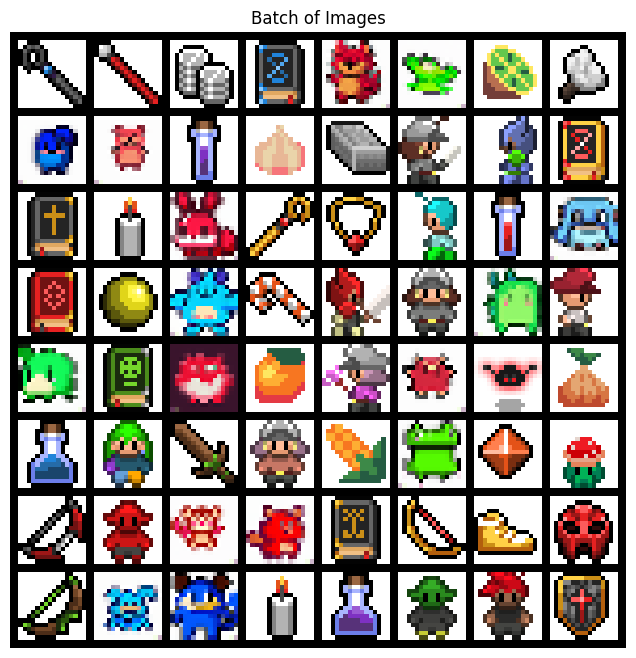

In [172]:
grid = vutils.make_grid(
    images,
    padding=2,
    normalize=True
)

'''
C: channels
H: height
W: width
B: batch size
'''
# CHW -> HWC for matplotlib
grid = grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Batch of Images")
plt.imshow(grid.numpy())
plt.show()

### Weights initialization

In [173]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)   
        nn.init.constant_(m.bias.data, 0)

### Generator

In [174]:

# Size of feature maps in generator
ngf = 32

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.gen = nn.Sequential(
            # LAYER 1: The "Foundation" Layer
            # Input: (z_dim) x 1 x 1
            # Output: (ngf * 8) x 4 x 4
            nn.ConvTranspose2d(
                in_channels = z_dim,
                out_channels = ngf * 8,
                kernel_size = 4,
                stride = 1,
                padding = 0,
                bias = False
            ),
            nn.BatchNorm2d(num_features = ngf * 8),
            nn.ReLU(inplace = True),
            
            # LAYER 2: First Upsample
            # Input: (ngf * 8) x 4 x 4
            # Output: (ngf * 4) x 8 x 8
            nn.ConvTranspose2d(
                in_channels = ngf * 8,
                out_channels = ngf * 4,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            nn.BatchNorm2d(num_features = ngf * 4),
            nn.ReLU(inplace = True),
            
            # LAYER 3: Final Upsample to 16x16 Sprite
            # Input: (ngf * 4) x 8 x 8
            # Output: (nc) x 16 x 16
            nn.ConvTranspose2d(
                in_channels = ngf * 4,
                out_channels = nc,
                kernel_size = 4,
                stride = 2,
                padding = 1,
                bias = False
            ),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.gen(x)


In [175]:
'''
import torch.nn as nn
ngf = 32
class Generator(nn.Module):
    def __init__(self, ngpu, z_dim=64, ngf=32, nc=3):
        super().__init__()
        self.ngpu = ngpu

        self.gen = nn.Sequential(
            # z: (z_dim) x 1 x 1 -> (ngf*8) x 4 x 4
            nn.ConvTranspose2d(z_dim, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # 4x4 -> 8x8 (Upsample + Conv)
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(ngf * 8, ngf * 4, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # 8x8 -> 16x16 (Upsample + Conv)
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(ngf * 4, nc, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)
'''

'\nimport torch.nn as nn\nngf = 32\nclass Generator(nn.Module):\n    def __init__(self, ngpu, z_dim=64, ngf=32, nc=3):\n        super().__init__()\n        self.ngpu = ngpu\n\n        self.gen = nn.Sequential(\n            # z: (z_dim) x 1 x 1 -> (ngf*8) x 4 x 4\n            nn.ConvTranspose2d(z_dim, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),\n            nn.BatchNorm2d(ngf * 8),\n            nn.ReLU(True),\n\n            # 4x4 -> 8x8 (Upsample + Conv)\n            nn.Upsample(scale_factor=2, mode="nearest"),\n            nn.Conv2d(ngf * 8, ngf * 4, kernel_size=3, stride=1, padding=1, bias=False),\n            nn.BatchNorm2d(ngf * 4),\n            nn.ReLU(True),\n\n            # 8x8 -> 16x16 (Upsample + Conv)\n            nn.Upsample(scale_factor=2, mode="nearest"),\n            nn.Conv2d(ngf * 4, nc, kernel_size=3, stride=1, padding=1, bias=False),\n            nn.Tanh()\n        )\n\n    def forward(self, x):\n        return self.gen(x)\n'

In [176]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(64, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)


### Discriminator

In [ ]:
# Size of feature maps in discriminator
ndf = 32

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            
            # --- LAYER 1: THE INPUT LAYER ---
            # Input: (nc) x 16 x 16
            # Output: (ndf) x 8 x 8
            nn.Conv2d(
                in_channels  = nc,
                out_channels = ndf,
                kernel_size  = 4,
                stride       = 2, # Halves the dimension
                padding      = 1,
                bias         = False
            ),
            # Note: No BatchNorm in the first layer of the Discriminator (DCGAN rule)
            nn.LeakyReLU(0.2, inplace=True),

            # --- LAYER 2: THE COMPRESSION LAYER ---
            # Input: (ndf) x 8 x 8
            # Output: (ndf * 2) x 4 x 4
            nn.Conv2d(
                in_channels  = ndf,
                out_channels = ndf * 2,
                kernel_size  = 4,
                stride       = 2, # Halves the dimension
                padding      = 1,
                bias         = False
            ),
            nn.BatchNorm2d(num_features = ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # --- LAYER 3: THE CLASSIFICATION LAYER ---
            # Input: (ndf * 2) x 4 x 4
            # Output: 1 x 1 x 1 (A single probability score)
            nn.Conv2d(
                in_channels  = ndf * 2,
                out_channels = 1,
                kernel_size  = 4,
                stride       = 1, # No more downsampling
                padding      = 0,
                bias         = False
            ),
            nn.Sigmoid() # Outputs a value between 0 (Fake) and 1 (Real)
        )

    def forward(self, x):
        return self.disc(x)

In [178]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (6): Sigmoid()
  )
)


### Loss Function and Optimizers

In [ ]:
# Learning rate for optimizers
lrG = 0.0002  # Generator learning rate
lrD = 0.0002 # Discriminator learning rate

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5
beta2 = 0.999

# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lrD, betas=(beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(beta1, beta2))

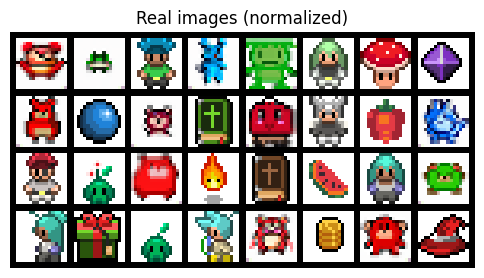

In [180]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

real_images, _ = next(iter(loader))   # unpack (images, labels)
grid = vutils.make_grid(real_images[:32], normalize=True, padding=2)


plt.figure(figsize=(6,6))
plt.axis("off")
plt.title("Real images (normalized)")
plt.imshow(np.transpose(grid.cpu(), (1,2,0)))
plt.show()


In [181]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, z_dim, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/20][0/1397]	Loss_D: 1.6101	Loss_G: 0.5401	D(x): 0.5457	D(G(z)): 0.6162 / 0.5885
[0/20][50/1397]	Loss_D: 2.0328	Loss_G: 0.3639	D(x): 0.5430	D(G(z)): 0.7516 / 0.6966
[0/20][100/1397]	Loss_D: 1.7926	Loss_G: 0.5585	D(x): 0.4613	D(G(z)): 0.6300 / 0.5741
[0/20][150/1397]	Loss_D: 1.7369	Loss_G: 0.5480	D(x): 0.4842	D(G(z)): 0.6293 / 0.5798
[0/20][200/1397]	Loss_D: 1.5396	Loss_G: 0.6030	D(x): 0.5220	D(G(z)): 0.5837 / 0.5488
[0/20][250/1397]	Loss_D: 1.6172	Loss_G: 0.5819	D(x): 0.4733	D(G(z)): 0.5764 / 0.5601
[0/20][300/1397]	Loss_D: 1.6288	Loss_G: 0.5847	D(x): 0.4541	D(G(z)): 0.5650 / 0.5583
[0/20][350/1397]	Loss_D: 1.5629	Loss_G: 0.6235	D(x): 0.4594	D(G(z)): 0.5416 / 0.5368
[0/20][400/1397]	Loss_D: 1.5455	Loss_G: 0.6152	D(x): 0.4705	D(G(z)): 0.5446 / 0.5410
[0/20][450/1397]	Loss_D: 1.5422	Loss_G: 0.6222	D(x): 0.4681	D(G(z)): 0.5406 / 0.5373
[0/20][500/1397]	Loss_D: 1.4929	Loss_G: 0.6317	D(x): 0.4853	D(G(z)): 0.5352 / 0.5322
[0/20][550/1397]	Loss_D: 1.4717	Loss_G: 0.

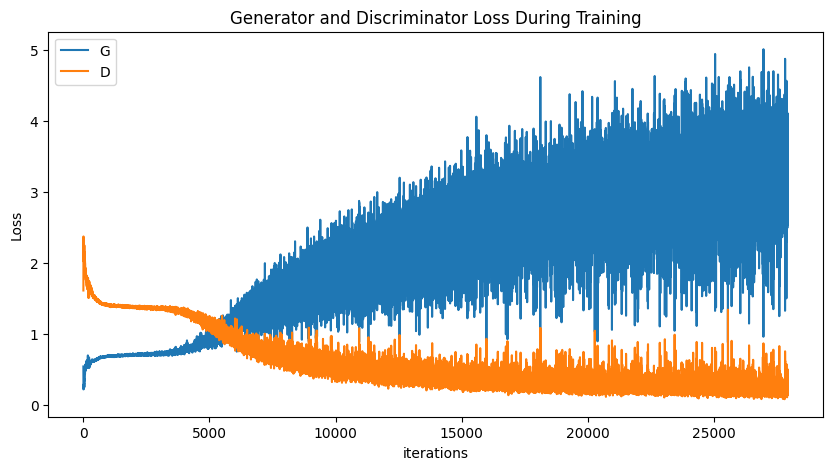

In [182]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

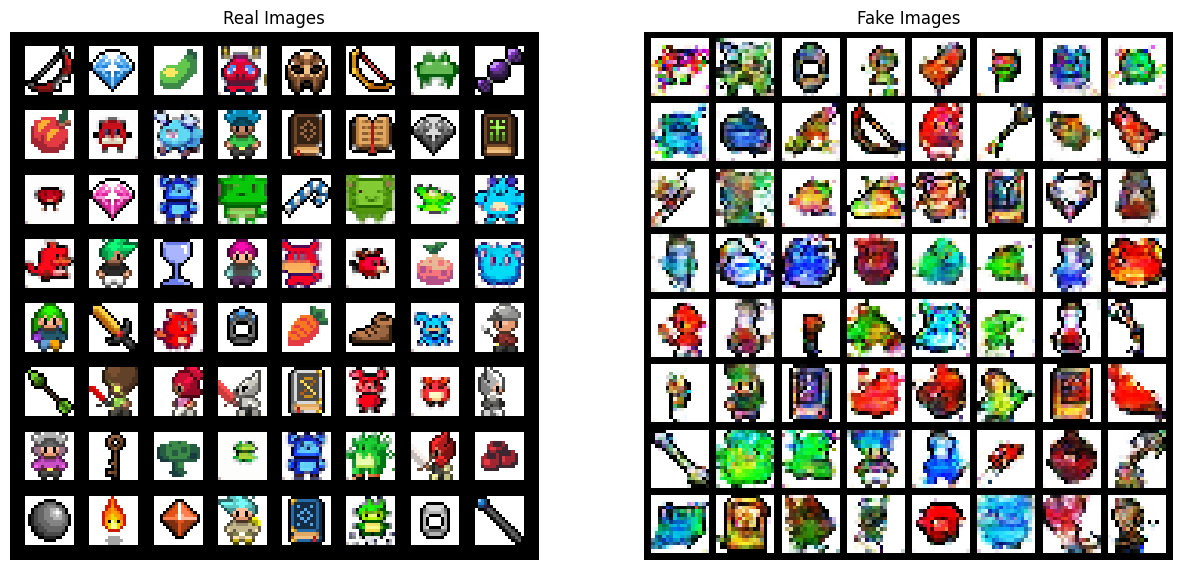

In [183]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

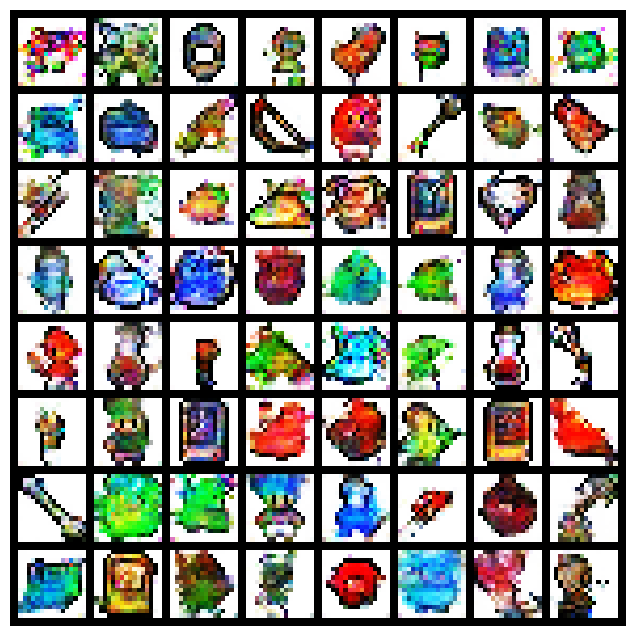

In [184]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

EVALUATION

In [185]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision.utils as vutils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import kagglehub
import os

In [186]:
import numpy as np, os, torch
import kagglehub
from torch.utils.data import TensorDataset, DataLoader

# 1) Download
path = kagglehub.dataset_download("ebrahimelgazar/pixel-art")
print("Path:", path)

labels_path = os.path.join(path, "sprites_labels.npy")
data_path   = os.path.join(path, "sprites.npy")

# 2) Load numpy
labels = np.load(labels_path)
data   = np.load(data_path)

print("Raw data:", data.shape, data.dtype)
print("Raw labels:", labels.shape, labels.dtype)

# 3) To torch
images_tensor = torch.tensor(data, dtype=torch.float32)     # [0..255]
labels_tensor = torch.tensor(labels, dtype=torch.float32)   # one-hot likely

# 4) HWC -> CHW
images_tensor = images_tensor.permute(0, 3, 1, 2)           # (N,C,H,W)
print("After permute:", images_tensor.shape)

# 5) Normalize to [-1, 1]
images_tensor = images_tensor / 255.0
images_tensor = (images_tensor - 0.5) / 0.5
print("After normalize min/max:", images_tensor.min().item(), images_tensor.max().item())

# 6) One-hot -> class id
if labels_tensor.ndim > 1:
    labels_tensor = labels_tensor.argmax(dim=1).long()
print("Labels:", labels_tensor.shape, labels_tensor.dtype, "unique:", torch.unique(labels_tensor))

# 7) Dataset + loader
dataset = TensorDataset(images_tensor, labels_tensor)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("Device:", device)
print("Dataset size:", len(dataset))


Path: C:\Users\lukma\.cache\kagglehub\datasets\ebrahimelgazar\pixel-art\versions\1
Raw data: (89400, 16, 16, 3) uint8
Raw labels: (89400, 5) float64
After permute: torch.Size([89400, 3, 16, 16])
After normalize min/max: -1.0 1.0
Labels: torch.Size([89400]) torch.int64 unique: tensor([0, 1, 2, 3, 4])
Device: cuda:0
Dataset size: 89400


In [187]:
imgs_real, y = next(iter(loader))
print(imgs_real.shape, imgs_real.min().item(), imgs_real.max().item())


torch.Size([64, 3, 16, 16]) -1.0 1.0


In [188]:
torch.manual_seed(42)

N = len(dataset)
n_train = int(0.8 * N)
n_test  = N - n_train

eval_train_set, eval_test_set = random_split(dataset, [n_train, n_test])


eval_train_loader = DataLoader(eval_train_set, batch_size=batch_size, shuffle=True,  num_workers=workers, pin_memory=True)
eval_test_loader  = DataLoader(eval_test_set,  batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True)

print("Train/Test:", len(eval_train_set), len(eval_test_set))
print("Train/Test:", (len(eval_train_set)/(len(eval_train_set)+len(eval_test_set))), (len(eval_test_loader))/(len(eval_test_loader)+len(eval_train_loader)))


Train/Test: 71520 17880
Train/Test: 0.8 0.20028612303290416


In [189]:
torch.manual_seed(42)
g = torch.Generator().manual_seed(42)

N = len(dataset)
n_train = int(0.8 * N)
n_test  = N - n_train

eval_train_set, eval_test_set = random_split(dataset, [n_train, n_test], generator=g)

eval_train_loader = DataLoader(eval_train_set, batch_size=batch_size, shuffle=True,  num_workers=workers, pin_memory=True)
eval_test_loader  = DataLoader(eval_test_set,  batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True)

print("Train/Test:", len(eval_train_set), len(eval_test_set))
print("Ratio:", len(eval_train_set)/N, len(eval_test_set)/N)

Train/Test: 71520 17880
Ratio: 0.8 0.2


In [190]:
netD.eval()
for p in netD.parameters():
    p.requires_grad = False

@torch.no_grad()
def get_scores_real(loader):
    scores, labels = [], []
    for imgs, y in loader:
        imgs = imgs.to(device)

        s = netD(imgs)
        s = s.view(s.size(0), -1).mean(dim=1)  # (N,)
        scores.append(s.cpu().numpy())
        labels.append(y.cpu().numpy())
    return np.concatenate(scores), np.concatenate(labels)

@torch.no_grad()
def get_scores_fake(netG, n_samples, batch_size=128, nz=64):
    scores = []
    netG.eval()
    for i in range(0, n_samples, batch_size):
        cur = min(batch_size, n_samples - i)
        z = torch.randn(cur, nz, 1, 1, device=device)
        fake = netG(z)
        s = netD(fake)
        s = s.view(s.size(0), -1).mean(dim=1)
        scores.append(s.cpu().numpy())
    return np.concatenate(scores)

real_scores, real_labels = get_scores_real(eval_test_loader)
fake_scores = get_scores_fake(netG, n_samples=len(real_scores), batch_size=batch_size, nz=64)

print(real_scores.shape, fake_scores.shape)
print("Real mean/std:", real_scores.mean(), real_scores.std())
print("Fake mean/std:", fake_scores.mean(), fake_scores.std())


(17880,) (17880,)
Real mean/std: 0.8124032 0.1440638
Fake mean/std: 0.17648144 0.1855798


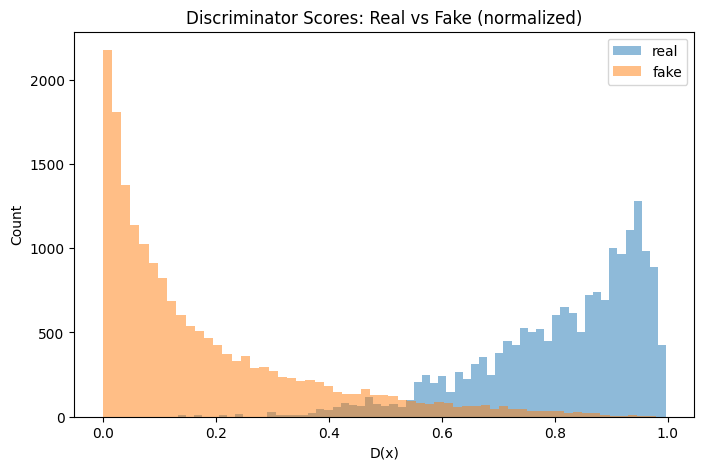

In [191]:
plt.figure(figsize=(8,5))
plt.hist(real_scores, bins=60, alpha=0.5, label="real")
plt.hist(fake_scores, bins=60, alpha=0.5, label="fake")
plt.title("Discriminator Scores: Real vs Fake (normalized)")
plt.xlabel("D(x)")
plt.ylabel("Count")
plt.legend()
plt.show()


In [192]:
def cohens_d(a, b):
    a = np.asarray(a); b = np.asarray(b)
    na, nb = len(a), len(b)
    sa, sb = a.var(ddof=1), b.var(ddof=1)
    s = np.sqrt(((na-1)*sa + (nb-1)*sb) / (na+nb-2))
    return (a.mean() - b.mean()) / (s + 1e-12)

print("Real mean/std:", real_scores.mean(), real_scores.std())
print("Fake mean/std:", fake_scores.mean(), fake_scores.std())
print("Cohen's d (real - fake):", cohens_d(real_scores, fake_scores))


Real mean/std: 0.8124032 0.1440638
Fake mean/std: 0.17648144 0.1855798
Cohen's d (real - fake): 3.8278918


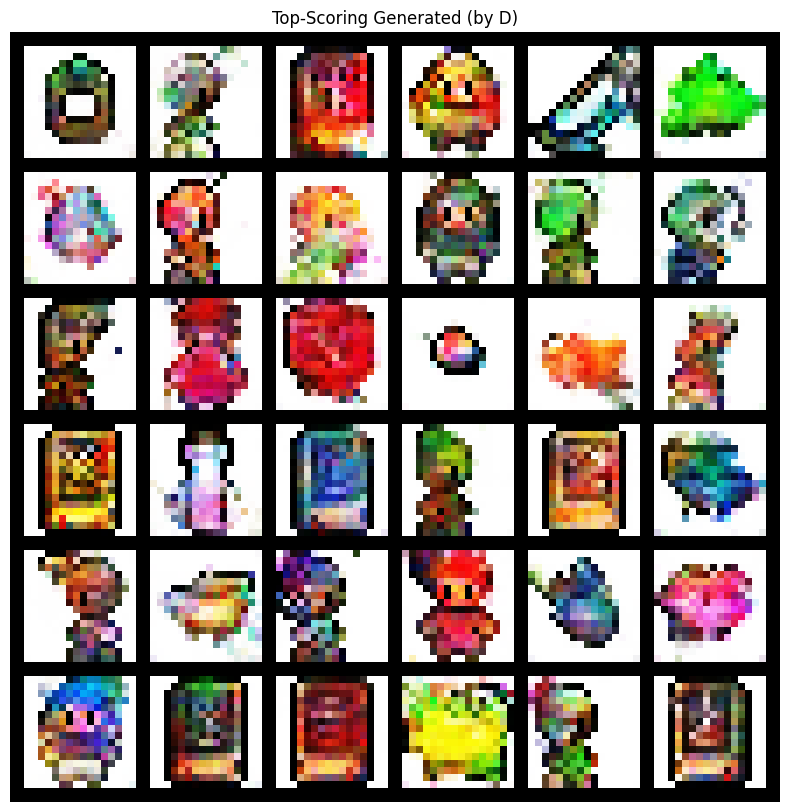

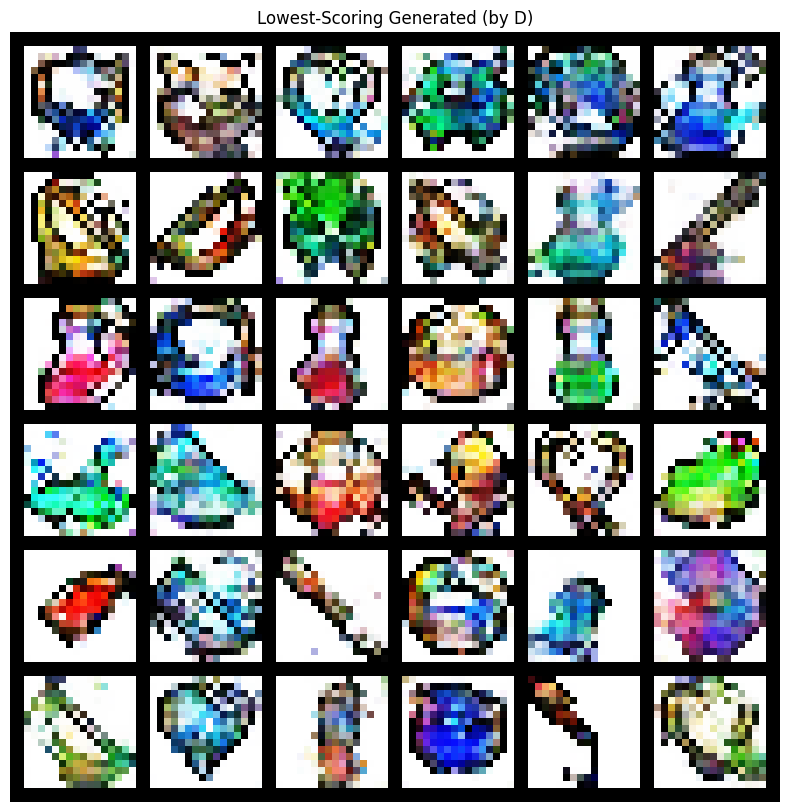

Best score range: 0.5095962 to 0.96983385
Worst score range: 0.00015164718 to 0.008430008


In [193]:
@torch.no_grad()
def sample_fake_with_scores(netG, n=512, nz=64):
    z = torch.randn(n, nz, 1, 1, device=device)
    fake = netG(z)
    s = netD(fake).view(n, -1).mean(dim=1).cpu().numpy()
    return fake.cpu(), s

fake_imgs, fake_s = sample_fake_with_scores(netG, n=512, nz=64)

best_idx  = np.argsort(fake_s)[-36:]
worst_idx = np.argsort(fake_s)[:36]

grid_best  = vutils.make_grid(fake_imgs[best_idx],  nrow=6, normalize=True)
grid_worst = vutils.make_grid(fake_imgs[worst_idx], nrow=6, normalize=True)

plt.figure(figsize=(10,10))
plt.imshow(np.transpose(grid_best.numpy(), (1,2,0)))
plt.axis("off")
plt.title("Top-Scoring Generated (by D)")
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(np.transpose(grid_worst.numpy(), (1,2,0)))
plt.axis("off")
plt.title("Lowest-Scoring Generated (by D)")
plt.show()

print("Best score range:", fake_s[best_idx].min(), "to", fake_s[best_idx].max())
print("Worst score range:", fake_s[worst_idx].min(), "to", fake_s[worst_idx].max())
